In [1]:
## conda env Weather_Prediction

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import xarray as xr
import rioxarray ## what we need from rioxarray can be done using rio acessor
import regionmask

In [2]:
## lets load the data

data = xr.open_dataset("data_sfc.nc")
data

<xarray.Dataset> Size: 63MB
Dimensions:     (valid_time: 2920, latitude: 34, longitude: 79)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 23kB 2010-01-01 ... 2010-12-31T21...
  * latitude    (latitude) float64 272B 48.75 48.0 47.25 ... 25.5 24.75 24.0
  * longitude   (longitude) float64 632B -125.0 -124.2 -123.5 ... -67.25 -66.5
Data variables:
    d2m         (valid_time, latitude, longitude) float32 31MB ...
    t2m         (valid_time, latitude, longitude) float32 31MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-30T01:51 GRIB to CDM+CF via cfgrib-0.9.1...

In [3]:
df=data.to_dataframe() ## this step is not necessary. but it gives a visual aid
df

d2m         t2m
valid_time          latitude longitude                        
2010-01-01 00:00:00 48.75    -125.00    277.681854  279.335510
                             -124.25    276.716034  277.768127
                             -123.50    276.760956  277.172424
                             -122.75    276.804901  276.965393
                             -122.00    274.138885  274.655823
...                                            ...         ...
2010-12-31 21:00:00 24.00    -69.50     287.732727  295.728790
                             -68.75     287.549133  295.571564
                             -68.00     287.462219  295.528595
                             -67.25     287.574524  295.526642
                             -66.50     288.110657  295.060822

[7843120 rows x 2 columns]

##  Lets begin by visualizing the data

In [4]:
## the data is multi-dimensional. the plot will be for an instant of time in a grid
# Slice the data by time and just the single variable for plotting purposes

instant = "2010-01-01T00:00:00.000000000"

instant_data = data["t2m"].sel(valid_time=slice(instant))
instant_data

<xarray.DataArray 't2m' (valid_time: 1, latitude: 34, longitude: 79)> Size: 11kB
array([[[279.3355 , 277.76813, ..., 261.94977, 259.1812 ],
        [282.05328, 278.98004, ..., 262.482  , 261.04254],
        ...,
        [290.84235, 291.05817, ..., 295.4156 , 295.97614],
        [290.9615 , 290.96735, ..., 295.69977, 296.09723]]], dtype=float32)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 8B 2010-01-01
  * latitude    (latitude) float64 272B 48.75 48.0 47.25 ... 25.5 24.75 24.0
  * longitude   (longitude) float64 632B -125.0 -124.2 -123.5 ... -67.25 -66.5
Attributes: (12/33)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      2686
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_number:                              0
    GRIB_surface:                             0.0

In [5]:
crs=instant_data.rio.crs ## the rio accessor
print(crs)  ## note that there no associated crs with the data

None


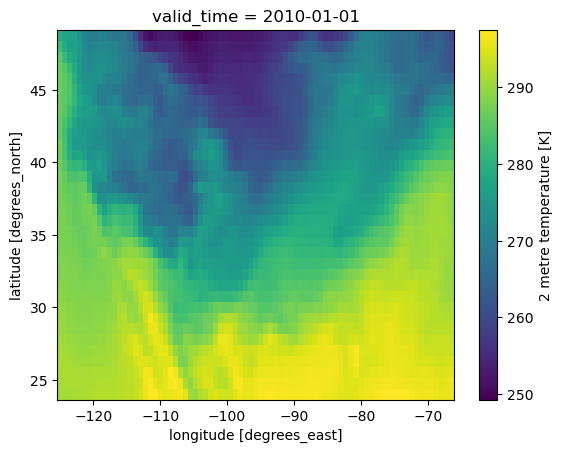

In [6]:
## an average plot

instant_data.plot() 

Text(0.5, 1.0, '2m Temperature on Jan 1 at 2010 00:00')

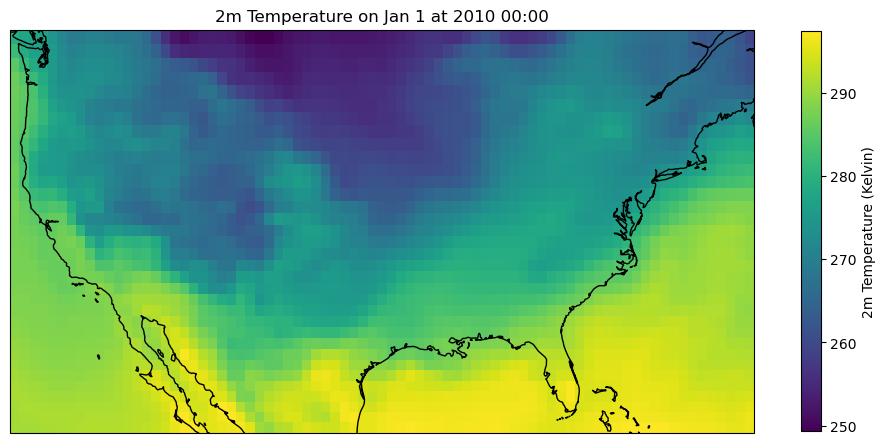

In [7]:
## improve the plot quality

fig = plt.figure(figsize=(12, 8))

p=instant_data.plot(subplot_kws=dict(projection=ccrs.Mercator()),  ## projection of the plot
                                      transform=ccrs.PlateCarree(),  ## projection of the data
                                       cbar_kwargs={"label": "2m Temperature (Kelvin)",'shrink':0.65})

p.axes.coastlines()
plt.title('2m Temperature on Jan 1 at 2010 00:00')


#### Note the fact that, in the figure below,  despite the fact that the data was downloaded over a rectangle, when it is projected in the AlbersEqualArea projection, the raster gets curved

Text(0.5, 1.0, '2m Temperature on Jan 1 2010 at 00:00')

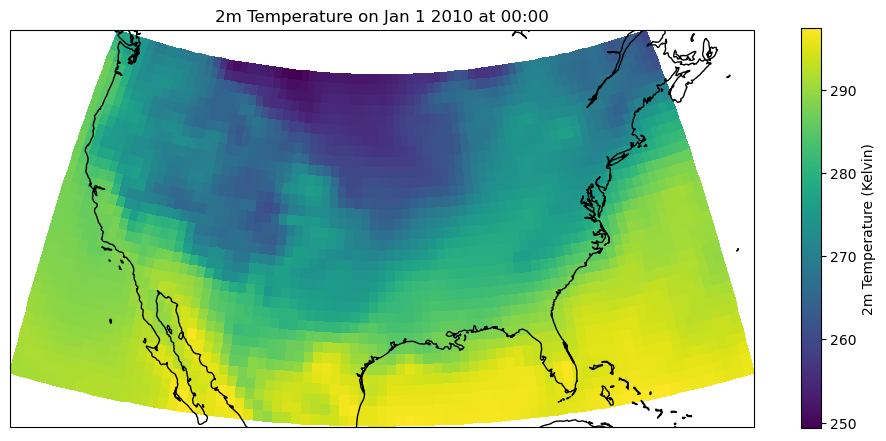

In [8]:
## Plot it in AlbersEqualArea projection

extent=[-125, -66.5, 48.75,24 ] ## the extent of CONUS data that is also shown in the dataset named "data"

central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

fig = plt.figure(figsize=(12, 8))

p=instant_data.plot(subplot_kws=dict({'projection':ccrs.LambertAzimuthalEqualArea(central_lon, central_lat)}),
                                        transform=ccrs.PlateCarree(), 
                                          cbar_kwargs={"label": "2m Temperature (Kelvin)",'shrink':0.65} )

p.axes.coastlines()
plt.title('2m Temperature on Jan 1 2010 at 00:00')

#### Include state in the raster plot

In [9]:
## Lets load the shapefile

SHAPE_PATH = os.path.join("State_shapefile",'cb_2018_us_state_500k.shp')
state_shape = gpd.read_file(SHAPE_PATH)
state_shape.head()


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


In [10]:
print('The CRS of the SHAPE file is:', state_shape.crs)
state_shapes=state_shape.drop([13,27, 36, 37, 38,42, 44, 45 ]) ## get rid of alaska and other territories

The CRS of the SHAPE file is: EPSG:4269


#### Perhaps the CRS of the xarray dataset is not defined that is why combining the xarray dataset with shapefile in a different projection is not possible, for example: LambertAzimuthalEqualArea. That is the only reason I could think of. Perhaps, that is why only the default (Platecarree) projection works which has been plotted below.  

Text(0.5, 1.0, "'2m Temperature on Jan 1 2010 at 00:00'")

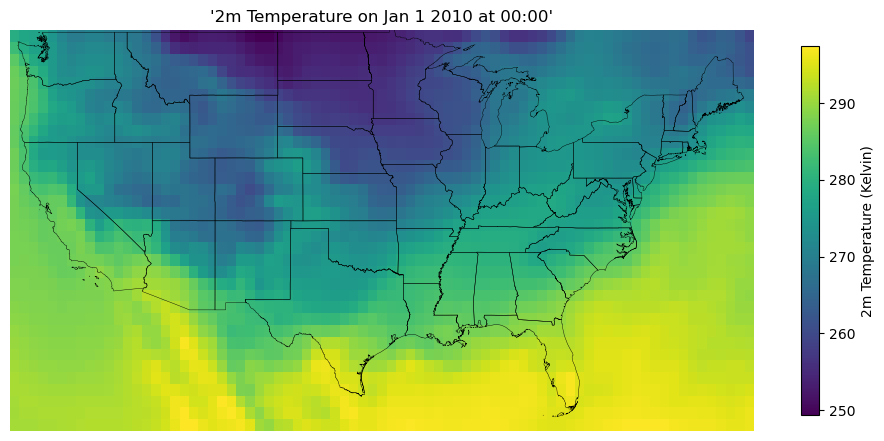

In [11]:
fig = plt.figure(figsize=(12, 8))

# create the map using the cartopy

ax = plt.subplot(1,1,1)
instant_data.plot(cbar_kwargs={"label": "2m Temperature (Kelvin)",'shrink':0.60})
state_shapes.plot(facecolor='none', edgecolor='black', ax=ax, linewidth=0.3)
ax.set_axis_off()
ax.set_title("'2m Temperature on Jan 1 2010 at 00:00'")



## End of Plot, lets begin dealing with data

In [12]:
## lets resamle the data to that of 1 Year
## that is, this is the 1 year average
year_avg = data.resample(valid_time='1YE').mean(dim='valid_time')
year_avg

<xarray.Dataset> Size: 22kB
Dimensions:     (valid_time: 1, latitude: 34, longitude: 79)
Coordinates:
  * latitude    (latitude) float64 272B 48.75 48.0 47.25 ... 25.5 24.75 24.0
  * longitude   (longitude) float64 632B -125.0 -124.2 -123.5 ... -67.25 -66.5
  * valid_time  (valid_time) datetime64[ns] 8B 2010-12-31
Data variables:
    d2m         (valid_time, latitude, longitude) float32 11kB 280.2 ... 293.5
    t2m         (valid_time, latitude, longitude) float32 11kB 282.7 ... 297.4
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-30T01:51 GRIB to CDM+CF via cfgrib-0.9.1...

In [13]:
df=year_avg.to_dataframe()
df

d2m         t2m
valid_time latitude longitude                        
2010-12-31 48.75    -125.00    280.158722  282.717682
                    -124.25    279.476868  282.623596
                    -123.50    279.457245  283.005524
                    -122.75    279.182251  282.910004
                    -122.00    276.495148  280.681885
...                                   ...         ...
           24.00    -69.50     293.573669  297.577881
                    -68.75     293.532562  297.538727
                    -68.00     293.503845  297.490417
                    -67.25     293.475891  297.458191
                    -66.50     293.459106  297.428833

[2686 rows x 2 columns]

In [14]:
state_names=state_shapes['NAME'].tolist()
state_names[:5] ## first 5 name

['Mississippi', 'North Carolina', 'Oklahoma', 'Virginia', 'West Virginia']

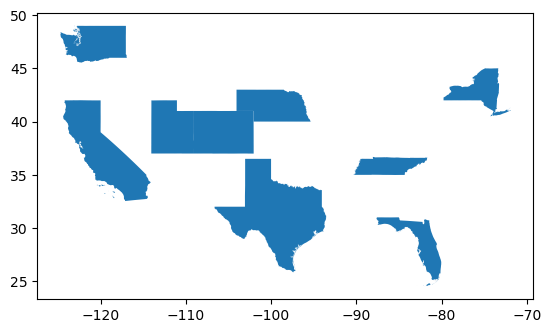

In [15]:
## name of the states which we want to find the average of the raster
few_states = state_shapes[state_shapes.NAME.isin([
 'Florida', 'Nebraska', 'Washington','Texas', 'California', 'Colorado','Utah','Tennessee','New York'])]
few_states.plot()
plt.show()


In [16]:
# Create a 3d mask - this contains the true / false values identifying pixels
# inside vs outside of the mask region

mask_states = regionmask.mask_3D_geopandas(few_states, 
                                                year_avg.longitude, 
                                                year_avg.latitude)
mask_states

<xarray.DataArray 'mask' (region: 9, latitude: 34, longitude: 79)> Size: 24kB
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False,  True,  True, ..., False, False, False],
        [False, False,  True, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * latitude   (latitude) float64 272B 48.75 48.0 47.25 46.5 ... 25.5 24.75 24.0
  * longitude  (longitude) float64 632B -125.0 -124.2 -123.5 ... -67.25 -66.5
  * region     (region) int64 72B 9 10 11 15 16 21 22 23 25
Attributes:
    standard_name:  region

In [17]:
# Apply the mask for name of the states
df_masked = year_avg.where(mask_states)
df_masked

<xarray.Dataset> Size: 194kB
Dimensions:     (valid_time: 1, latitude: 34, longitude: 79, region: 9)
Coordinates:
  * latitude    (latitude) float64 272B 48.75 48.0 47.25 ... 25.5 24.75 24.0
  * longitude   (longitude) float64 632B -125.0 -124.2 -123.5 ... -67.25 -66.5
  * valid_time  (valid_time) datetime64[ns] 8B 2010-12-31
  * region      (region) int64 72B 9 10 11 15 16 21 22 23 25
Data variables:
    d2m         (valid_time, latitude, longitude, region) float32 97kB nan .....
    t2m         (valid_time, latitude, longitude, region) float32 97kB nan .....
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-30T01:51 GRIB to CDM+CF via cfgrib-0.9.1...

In [18]:
df=df_masked.to_dataframe()
df

d2m  t2m
valid_time latitude longitude region          
2010-12-31 48.75    -125.0    9       NaN  NaN
                              10      NaN  NaN
                              11      NaN  NaN
                              15      NaN  NaN
                              16      NaN  NaN
...                                   ...  ...
           24.00    -66.5     16      NaN  NaN
                              21      NaN  NaN
                              22      NaN  NaN
                              23      NaN  NaN
                              25      NaN  NaN

[24174 rows x 2 columns]

In [19]:
summary = df_masked.groupby("valid_time").mean(["latitude", "longitude"])
summary.to_dataframe()

d2m         t2m
valid_time region                        
2010-12-31 9       288.242004  293.948853
           10      275.726227  283.407013
           11      275.940063  281.937500
           15      282.887817  292.199554
           16      276.480713  287.427460
           21      270.412781  280.643677
           22      270.980347  282.323486
           23      281.659637  288.583252
           25      276.804108  282.376770

In [20]:
## group by the valid time dimension. The result is same as above as there is only 1 time.
## this step is necessary to merge with the shape file

summary_2 = df_masked.groupby("region").mean(["latitude", "longitude","valid_time"])
summary_2.to_dataframe()

,d2m,t2m
region,,
9,288.242004,293.948853
10,275.726227,283.407013
11,275.940063,281.937500
15,282.887817,292.199554
16,276.480713,287.427460
21,270.412781,280.643677
22,270.980347,282.323486
23,281.659637,288.583252
25,276.804108,282.376770


In [21]:
state_avg=summary_2.to_dataframe()
type(state_avg)

pandas.core.frame.DataFrame

In [22]:
type(state_shapes)

geopandas.geodataframe.GeoDataFrame

In [23]:
shape_df=pd.DataFrame(state_shapes)
shape_df.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


In [24]:
## merge by index

final_df = pd.merge(state_shapes, state_avg, left_index=True, right_index=True, how='left')
final_df.head(11)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,d2m,t2m
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...",NaN,NaN
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",NaN,NaN
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6...",NaN,NaN
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...",NaN,NaN
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169...",NaN,NaN
5,22,01629543,0400000US22,22,LA,Louisiana,00,111897594374,23753621895,"MULTIPOLYGON (((-88.86770 29.86155, -88.86566 ...",NaN,NaN
6,26,01779789,0400000US26,26,MI,Michigan,00,146600952990,103885855702,"MULTIPOLYGON (((-83.19159 42.03537, -83.18993 ...",NaN,NaN
7,25,00606926,0400000US25,25,MA,Massachusetts,00,20205125364,7129925486,"MULTIPOLYGON (((-70.23405 41.28565, -70.22361 ...",NaN,NaN
8,16,01779783,0400000US16,16,ID,Idaho,00,214049787659,2391722557,"POLYGON ((-117.24267 44.39655, -117.23484 44.3...",NaN,NaN
9,12,00294478,0400000US12,12,FL,Florida,00,138949136250,31361101223,"MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ...",288.242004,293.948853


In [25]:
final_df=final_df.dropna() ## remove NaN
final_df

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,d2m,t2m
9,12,00294478,0400000US12,12,FL,Florida,00,138949136250,31361101223,"MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ...",288.242004,293.948853
10,31,01779792,0400000US31,31,NE,Nebraska,00,198956658395,1371829134,"POLYGON ((-104.05342 41.17054, -104.05324 41.1...",275.726227,283.407013
11,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"MULTIPOLYGON (((-122.57039 48.53785, -122.5686...",275.940063,281.937500
15,48,01779801,0400000US48,48,TX,Texas,00,676653171537,19006305260,"MULTIPOLYGON (((-94.71830 29.72885, -94.71721 ...",282.887817,292.199554
16,06,01779778,0400000US06,06,CA,California,00,403503931312,20463871877,"MULTIPOLYGON (((-118.60442 33.47855, -118.5987...",276.480713,287.427460
21,08,01779779,0400000US08,08,CO,Colorado,00,268422891711,1181621593,"POLYGON ((-109.06025 38.59933, -109.05954 38.7...",270.412781,280.643677
22,49,01455989,0400000US49,49,UT,Utah,00,212886221680,6998824394,"POLYGON ((-114.05296 37.59278, -114.05247 37.6...",270.980347,282.323486
23,47,01325873,0400000US47,47,TN,Tennessee,00,106802728188,2350123465,"POLYGON ((-90.31030 35.00429, -90.30988 35.009...",281.659637,288.583252
25,36,01779796,0400000US36,36,NY,New York,00,122049149763,19246994695,"MULTIPOLYGON (((-72.03683 41.24984, -72.03496 ...",276.804108,282.376770


In [26]:
type(final_df)

geopandas.geodataframe.GeoDataFrame

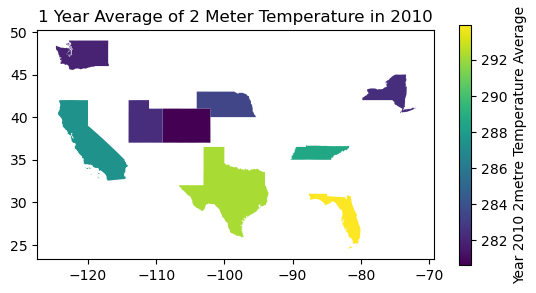

In [27]:
final_df.plot(column='t2m', legend=True, legend_kwds={"label": "Year 2010 2metre Temperature Average",
                                                                             "shrink":0.65})
plt.title('1 Year Average of 2 Meter Temperature in 2010')
plt.show()

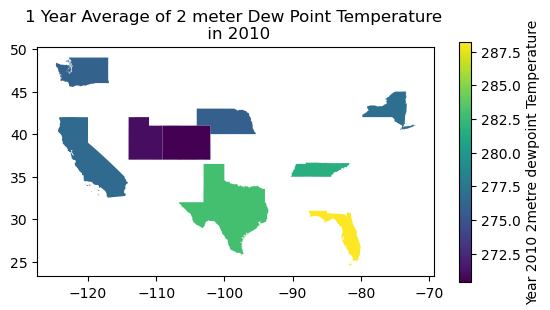

In [28]:
final_df.plot(column='d2m', legend=True, legend_kwds={"label": "Year 2010 2metre dewpoint Temperature", 
                                                                               "shrink":0.65})
plt.title('1 Year Average of 2 meter Dew Point Temperature \n in 2010')
plt.show()

## The reason why only a few name of the state has been considered is because after the list goes above 40, the function used in In[19] gives an error. That is a loop needs to be created which has been done in the next notebook.